# Inverting for geodetic slip rate from InSAR profile data

Gareth Funning, University of California, Riverside

This exercise, which follows on from a similar exercise based on GNSS data,  takes profiles through real InSAR velocity data, and solves for the slip rare and locking depth using the 1D arctangent model. 

## Contents

0. Dependencies
1. The 1D elastic dislocation model
2. Selecting GNSS stations around a fault
3. Projecting GNSS stations onto a profile
4. Projecting GNSS velocities into the fault-parallel direction
5. Forward 'trial-and-error' models
6. Using a grid search to identify a preferred model
7. References

## 0. Dependencies

This notebook makes use of a few dependencies. Make sure they're all installed before you get started, otherwise Jupyter will be sad...

In [13]:
# import your dependencies
import numpy as np
import pandas as pd
#from interparc import interparc
import utm
import matplotlib.pyplot as plt
import pygmt

## 1. InSAR velocity data 

In this exercise we are going to analyze pre-processed InSAR deformation velocities. These are supplied along with their corresponding line-of-sight (LOS) information. 

In [14]:
# data file names, directories, and sign convention
asc_tr = 'A137'
dsc_tr = 'D144'
signconvention = -1   # 1 if data are in range change, -1 if they are ground displacement

asc_file = asc_tr + '/' + asc_tr + '_masked_ll.grd'
asc_azi = asc_tr + '/ARIA_' + asc_tr + '_azimuthAngle_ll.grd'
asc_inc = asc_tr + '/ARIA_' + asc_tr + '_incidenceAngle_ll.grd'

dsc_file = dsc_tr + '/' + dsc_tr + '_masked_ll.grd'
dsc_azi = dsc_tr + '/ARIA_' + dsc_tr + '_azimuthAngle_ll.grd'
dsc_inc = dsc_tr + '/ARIA_' + dsc_tr + '_incidenceAngle_ll.grd'

print('ascending track ' + asc_tr + ', data file: ' + asc_file)
print('descending track ' + dsc_tr + ', data file: ' + dsc_file)

ascending track A137, data file: A137/A137_masked_ll.grd
descending track D144, data file: D144/D144_masked_ll.grd


## 2. Plotting InSAR velocities

What do the data look like?

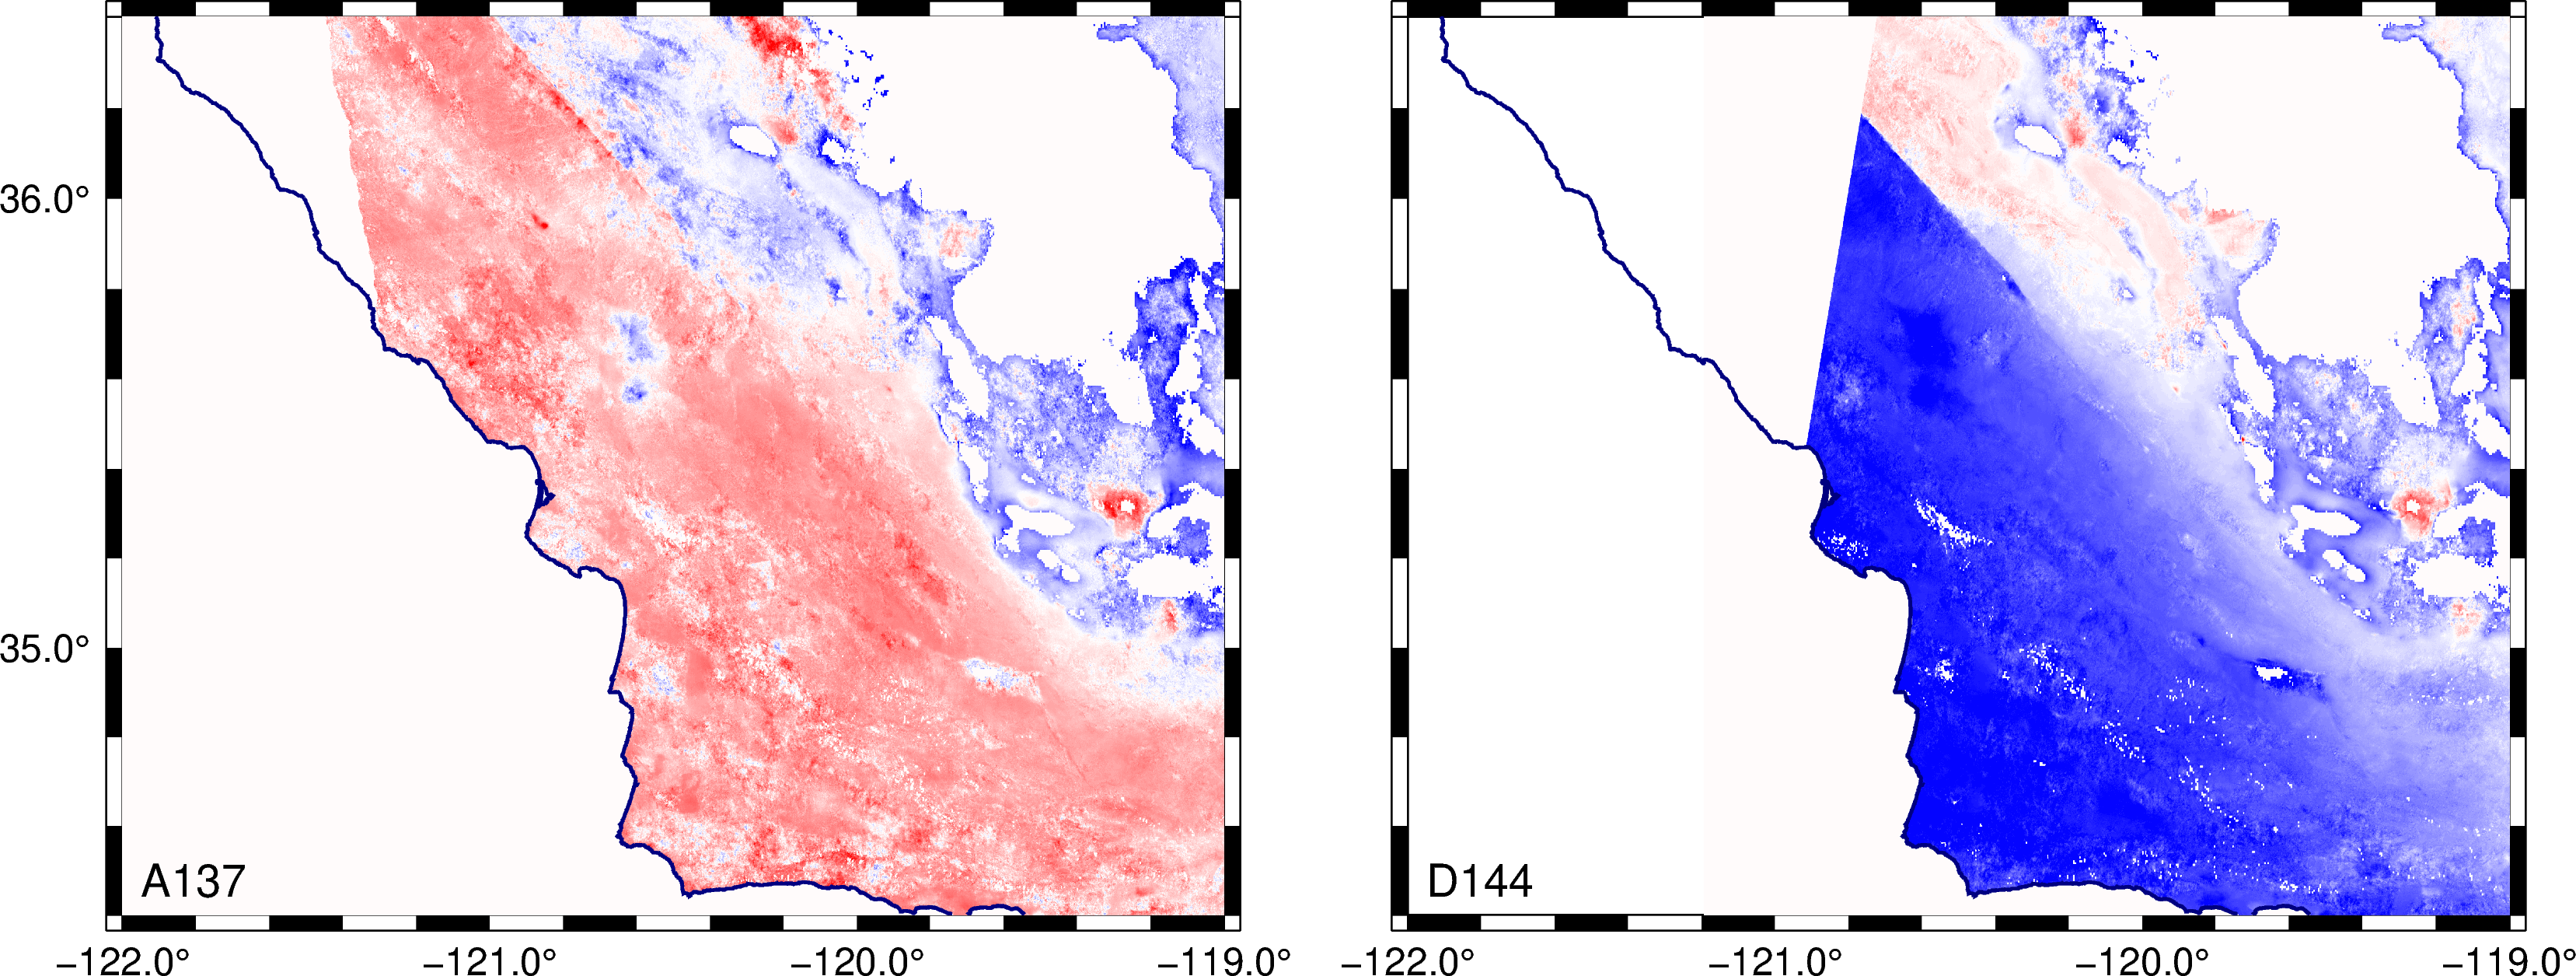

In [15]:
# let's plot some lines on a map!

# set up a bounding box
study_region=[-122,-119,34.4,36.4]  # [west, east, south, north]

# initiate a PyGMT figure 
fig = pygmt.Figure() 

# override some ugly (I think) defaults:
pygmt.config(FORMAT_GEO_MAP="ddd.x")

# make a colormap
pygmt.makecpt(cmap='polar', series=(-15, 15, 0.5), background="o")

# and let's get plotting!
fig.basemap(region=study_region, projection="M12c", frame=["a1f0.2","WeSn"])  # make a basemap frame
fig.grdimage(asc_file)                                                        # plot one data file
fig.coast(shorelines=["1/1p,navy","2/1p,navy"], borders=["1/0.5p,darkred"])   # coasts and borders
fig.text(text=asc_tr, position="BL", font="14p", offset="0.2c", justify="BL") # label the plot

fig.shift_origin(xshift="14c")                                                # shift the origin
fig.basemap(region=study_region, projection="M12c", frame=["a1f0.2","weSn"])  # and let's make another one!
fig.grdimage(dsc_file)                                                        # plot the other file
fig.coast(shorelines=["1/1p,navy","2/1p,navy"], borders=["1/0.5p,darkred"])   # coasts and borders
fig.text(text=dsc_tr, position="BL", font="14p", offset="0.2c", justify="BL") # label this one too

# and display!
fig.show(width=800)

Looks pretty good, right? Next we will figure out how to project these onto a profile!

## 3. Projecting InSAR data onto a profile

We will try and use the PyGMT command 'grdtrack' to sample these data files. grdtrack reads coordinates from text files or pandas data frames, and we will generate one of the latter. 

The first step is to ingest fault data, convert the locations into UTM (a rectilinear local coordinate system, which is more appropriate for this sort of analysis) and calculate the average strike:

In [16]:
# here are some example coordinates
fault_vertices_ll=np.array([[-120.287850, 35.733702],[-119.738844,35.182270]]) # [x1, y1], [x2, y2]

# some coordinate business
utm_zone = 11
utm_lett = 'S' # consult here if unsure: http://maps.unomaha.edu/Peterson/gis/notes/MapProjCoord.html

# convert the vertices to utm 
fault_vertex_utm1=utm.from_latlon(fault_vertices_ll[0,1],fault_vertices_ll[0,0],utm_zone,utm_lett)
fault_vertex_utm2=utm.from_latlon(fault_vertices_ll[1,1],fault_vertices_ll[1,0],utm_zone,utm_lett)

# and now let's calculate the strike
fault_dx=fault_vertex_utm2[0]-fault_vertex_utm1[0]    # find the vector components
fault_dy=fault_vertex_utm2[1]-fault_vertex_utm1[1]    # in the fault-parallel direction...
fault_length=np.sqrt(fault_dx**2+fault_dy**2)         # ...and do some Pythagoras

fault_dx=fault_dx/fault_length                        # make this a fault-parallel UNIT vector
fault_dy=fault_dy/fault_length                        # it will be helpful for later on

fault_strike=np.degrees(np.arctan2(fault_dx,fault_dy))

print('fault has strike {0:5.1f}, and length {1:4.1f} km'.format(fault_strike,fault_length/1000))


fault has strike 142.6, and length 79.0 km


Next, we will construct the profile coordinates. We'll pick the middle of the fault as our profile location. Once we specify dimensions of an area to sample, we will calculate the coordinates of a grid of points that we will use to sample the data files, project them back into geographical coordinates, and put them into a data frame. Simple (if a bit fiddly)!

In [78]:
# let's pick the center of the fault trace as the profile location
prof_x=(fault_vertex_utm1[0]+fault_vertex_utm2[0])/2    # x coordinate of profile center (in UTM) 
prof_y=(fault_vertex_utm1[1]+fault_vertex_utm2[1])/2    # y coordinate 

# how far off-fault do we want to select stations?
half_length = 50  # profile half-length in km
half_width = 2.5  # profile half-width in km 
pt_spacing = 0.5  # point spacing in km

# unit vector in the along-profile direction (90 degrees from strike)
prof_dx=np.sin(np.radians(fault_strike-90))
prof_dy=np.cos(np.radians(fault_strike-90))

# let's make vectors of along-profile and cross-profile distances
p=np.linspace(-half_length,half_length,round(2*half_length/pt_spacing)+1)  # p = along-profile distance
q=np.linspace(-half_width,half_width,round(2*half_width/pt_spacing)+1)     # q = cross-profile distance
vp=np.linspace(-half_length,half_length,2)                                 # the p coordinates of the corners of the profile
vq=np.linspace(-half_width,half_width,2)                                   # the q coordinates of the corners of the profile

# we can make grids of points in (p,q) coordinates
P, Q = np.meshgrid(p,q)                 # all the points we want to sample
VP = np.array([[vp], [np.flip(vp)]])    # the vertices of the area being sampled
VQ = np.array([[vq], [vq]]).T

# transform these coordinates into UTM
X=prof_x+P*prof_dx*1000+Q*fault_dx*1000       # x coordinates (in UTM) of sample points 
Y=prof_y+P*prof_dy*1000+Q*fault_dy*1000       # y coordinates (in UTM) of sample points
VX=prof_x+VP*prof_dx*1000+VQ*fault_dx*1000    # x coordinates of sample region vertices
VY=prof_y+VP*prof_dy*1000+VQ*fault_dy*1000    # y coordinates of sample region vertices

# let's get the UTM coordinates for the profile line, too
px=prof_x+1000*prof_dx*vp
py=prof_y+1000*prof_dy*vp

# flattening grids into single columns,  transform these into lat-long
pt_locs_ll=utm.to_latlon(X.reshape(-1),Y.reshape(-1),utm_zone,utm_lett)
vt_locs_ll=utm.to_latlon(VX.reshape(-1),VY.reshape(-1),utm_zone,utm_lett)
pf_locs_ll=utm.to_latlon(px,py,utm_zone,utm_lett)
pf_center_ll=utm.to_latlon(prof_x,prof_y,utm_zone,utm_lett)

# let's make data frames for these
samp_pts=pd.DataFrame({'longitude': pt_locs_ll[1], 'latitude': pt_locs_ll[0], 'P': P.reshape(-1), 'Q': Q.reshape(-1)})
samp_vts=pd.DataFrame({'longitude': vt_locs_ll[1], 'latitude': vt_locs_ll[0], 'P': VP.reshape(-1), 'Q': VQ.reshape(-1)})

If you like, you can see what these data frames look like:

In [79]:
# this is the sample points data frame
samp_pts

longitude   latitude     P    Q
0    -120.455122  35.190603 -50.0 -2.5
1    -120.450883  35.193462 -49.5 -2.5
2    -120.446645  35.196320 -49.0 -2.5
3    -120.442406  35.199179 -48.5 -2.5
4    -120.438167  35.202037 -48.0 -2.5
...          ...        ...   ...  ...
2206 -119.583868  35.713274  48.0  2.5
2207 -119.579571  35.716104  48.5  2.5
2208 -119.575273  35.718935  49.0  2.5
2209 -119.570974  35.721765  49.5  2.5
2210 -119.566676  35.724595  50.0  2.5

[2211 rows x 4 columns]

In [80]:
# and the data frame for the vertices of the area we are sampling
samp_vts

longitude   latitude     P    Q
0 -120.455122  35.190603 -50.0 -2.5
1 -119.601397  35.759643  50.0 -2.5
2 -119.566676  35.724595  50.0  2.5
3 -120.420313  35.155805 -50.0  2.5

Let's look at the locations and sizes of the profile area with another plot:

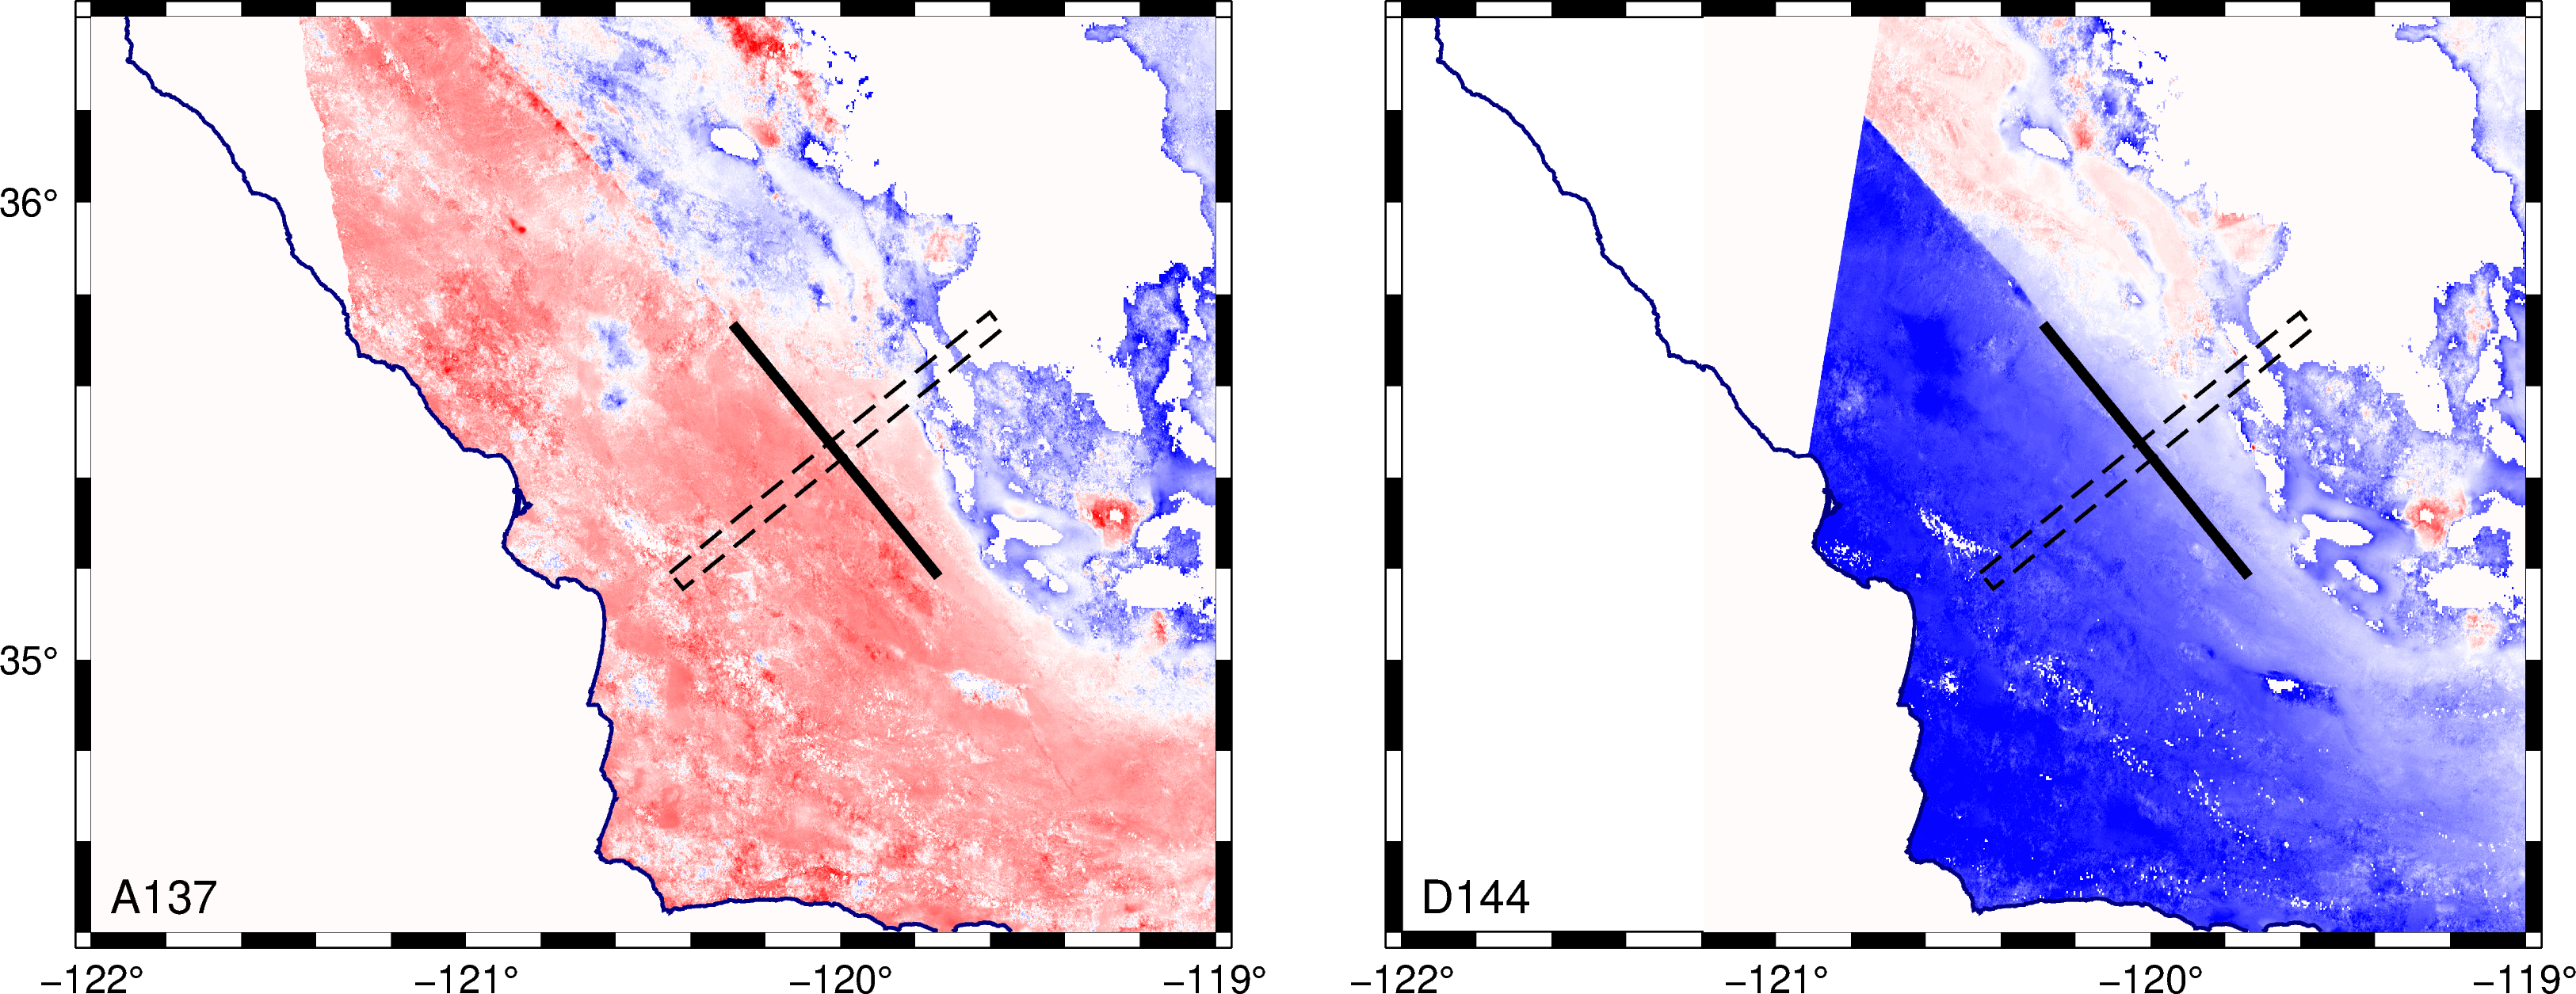

In [81]:
# plot the profile and sample area on a map!

# initiate a PyGMT figure 
fig = pygmt.Figure() 

# override some ugly (I think) defaults:
#pygmt.config(FORMAT_GEO_MAP="ddd.x")

# make a colormap
pygmt.makecpt(cmap='polar', series=(-15, 15, 0.5), background="o")

# and let's get plotting!
fig.basemap(region=study_region, projection="M12c", frame=["a1f0.2","WeSn"])  # make a basemap frame
fig.grdimage(asc_file)                                                        # plot one data file
fig.coast(shorelines=["1/1p,navy","2/1p,navy"], borders=["1/0.5p,darkred"])   # coasts and borders
fig.text(text=asc_tr, position="BL", font="14p", offset="0.2c", justify="BL") # label the plot
fig.plot(samp_vts["longitude"],samp_vts["latitude"], pen="1p,black,-",close=True)   # sample box
fig.plot(fault_vertices_ll[:,0],fault_vertices_ll[:,1],pen="3p,black")              # fault trace

fig.shift_origin(xshift="14c")                                                # shift the origin
fig.basemap(region=study_region, projection="M12c", frame=["a1f0.2","weSn"])  # and let's make another one!
fig.grdimage(dsc_file)                                                        # plot the other file
fig.coast(shorelines=["1/1p,navy","2/1p,navy"], borders=["1/0.5p,darkred"])   # coasts and borders
fig.text(text=dsc_tr, position="BL", font="14p", offset="0.2c", justify="BL") # label this one too
fig.plot(samp_vts["longitude"],samp_vts["latitude"], pen="1p,black,-",close=True)   # sample box
fig.plot(fault_vertices_ll[:,0],fault_vertices_ll[:,1],pen="3p,black")              # fault trace

# and display!
fig.show(width=800)


Look good? Then we shall proceed with data sampling! As mentioned, we will use pygmt.grdtrack to do this...

In [82]:
# here goes nothing!
samp_pts=pygmt.grdtrack(samp_pts,asc_file,newcolname=asc_tr,interpolation="n")  # add a column for the ascending data
samp_pts=pygmt.grdtrack(samp_pts,dsc_file,newcolname=dsc_tr,interpolation="n")  # add a column for the descending data

# we'll ignore rows that contain zeros in the two new data columns
samp_pts=samp_pts.loc[(samp_pts[[asc_tr, dsc_tr]] != 0).all(axis=1)]

That was easy! The effect is to add a couple of extra columns to 'samp_pts'. Let's have a look:

In [83]:
samp_pts

longitude   latitude     P    Q       A137       D144
0    -120.455122  35.190603 -50.0 -2.5   5.252339 -11.693758
1    -120.450883  35.193462 -49.5 -2.5   4.904813 -11.318884
2    -120.446645  35.196320 -49.0 -2.5   5.955338  -9.466749
3    -120.442406  35.199179 -48.5 -2.5   4.317297 -13.672194
4    -120.438167  35.202037 -48.0 -2.5   5.384472 -11.764817
...          ...        ...   ...  ...        ...        ...
2167 -119.751238  35.602773  28.5  2.5 -11.727766  -5.144620
2182 -119.686920  35.645298  36.0  2.5  -2.581117  -8.741392
2183 -119.682630  35.648132  36.5  2.5  -1.791075  -8.690937
2184 -119.678339  35.650966  37.0  2.5  -3.045165  -7.984952
2185 -119.674048  35.653800  37.5  2.5  -5.749124  -8.200552

[1818 rows x 6 columns]

And we can look at the values by plotting them with matplotlib:

In [84]:
samp_pts[asc_tr]

0        5.252339
1        4.904813
2        5.955338
3        4.317297
4        5.384472
          ...    
2167   -11.727766
2182    -2.581117
2183    -1.791075
2184    -3.045165
2185    -5.749124
Name: A137, Length: 1818, dtype: float64

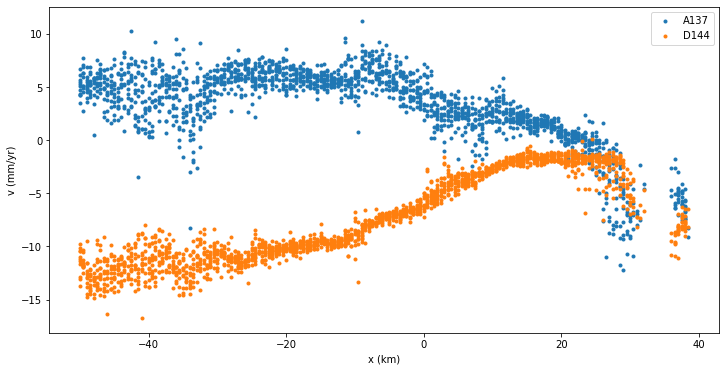

In [85]:
# initiate the plot
plt.figure(figsize=(12,6))

# plot the data as red inverted triangles with 2-sigma error bars
plt.scatter(samp_pts["P"], samp_pts[asc_tr], marker=".", label=asc_tr)  
plt.scatter(samp_pts["P"], samp_pts[dsc_tr], marker=".", label=dsc_tr)  
    
# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
plt.legend()

plt.show()

I think I can see an arctangent shape in there... the next step will be to fit it. For that, we will need to consider how the fault slip projects into satellite line-of-sight.

## 4. Deformation and line-of-sight

The data we have just sampled and plotted are line-of-sight (LOS) velocities, 1-dimensional measurements of the movement of the ground towards or away from the satellite. It is clear that the shape of the velocity profiles is quite different for the two different tracks, despite them covering the same time span (2014-2020) $-$ this is related to how the deformation projects into each LOS direction.

We can construct the unit LOS vectors from information on the azimuth and incidence angles that are generated during interferogram processing, provided here as two separate netCDF ('.grd') files, and in ISCE as a two layer (= channel) file, according to these specifications (pasted from one of the ISCE scripts):

"Two channel Line-Of-Sight geometry image (all angles in degrees). **Represents vector drawn from target to
platform**.
* Channel 1: Incidence angle **measured from vertical at target** (always +ve).
* Channel 2: Azimuth angle **measured from North in Anti-clockwise direction**."

The diagram below shows the imaging geometry and how it relates to these angles: 
<br>
<br>
<br>
<img src="azimuth_and_incidence.png" align="center" width=80%>
<br>
<br>
We can sample representative values of these angles from the files we have, by setting up a pandas data frame and using pygmt.grdtrack like before. Unlike before, however, we only are going to sample one location $-$ the center of the profile, whose coordinates we already know...

In [86]:
# make another pandas data frame, this time for the center of the profile
los_origin=pd.DataFrame({'longitude': pf_center_ll[1], 'latitude': pf_center_ll[0]}, index=[0])

# and use it to sample the LOS information
los_origin=pygmt.grdtrack(los_origin,asc_azi,newcolname='asc_azi',interpolation="n")
los_origin=pygmt.grdtrack(los_origin,asc_inc,newcolname='asc_inc',interpolation="n")
los_origin=pygmt.grdtrack(los_origin,dsc_azi,newcolname='dsc_azi',interpolation="n")
los_origin=pygmt.grdtrack(los_origin,dsc_inc,newcolname='dsc_inc',interpolation="n")

# and let's look at them
los_origin

longitude   latitude     asc_azi    asc_inc    dsc_azi    dsc_inc
0 -120.012397  35.458351 -261.464905  38.069359 -101.62265  41.634895

These angles can be related to the three components of the unit LOS pointing vector, $\bf{\hat{p}_{LOS}}$, the unit vector pointing from the satellite platform to the ground target, via the following expressions:

$$\bf{\hat{p}_{LOS}} = [\hat{p}_x, \hat{p}_y, \hat{p}_z] = [\sin\phi\sin\theta, -\cos\phi\sin\theta, -\cos\theta]$$

where $\phi$ is the azimuth angle and $\theta$ the incidence angle. We can evaluate them via some fiddly numpy trigonometry!

(And one more thing to deal with: the sign convention of the data. If the data are in range change, and positive velocity is away from the satellite, then this is the LOS vector we want, pointing towards the ground. But if the sign covention is 'ground displacement', i.e. positive displacement is towards the satellite, then we would want the LOS vector to point from the ground to the satellite, which is the case for the specific data we have here.)

In [87]:
# calculate the unit LOS vectors (satellite pointing to ground target)
asc_los=np.array([np.sin(np.radians(los_origin["asc_azi"]))*np.sin(np.radians(los_origin["asc_inc"])),
                  -np.cos(np.radians(los_origin["asc_azi"]))*np.sin(np.radians(los_origin["asc_inc"])),
                  -np.cos(np.radians(los_origin["asc_inc"]))])*signconvention

dsc_los=np.array([np.sin(np.radians(los_origin["dsc_azi"]))*np.sin(np.radians(los_origin["dsc_inc"])),
                  -np.cos(np.radians(los_origin["dsc_azi"]))*np.sin(np.radians(los_origin["dsc_inc"])),
                  -np.cos(np.radians(los_origin["dsc_inc"]))])*signconvention

wah=np.array([0.610, 0.092, -0.787])

# report the sign convention
if signconvention==1:
    print('range change sign convention')
elif signconvention==-1:
    print('ground displacement sign convention')
else:
    print('you may have messed up this sign convention thing, to be honest')

# and report your LOS vector
print('ascending track LOS vector: [{0:5.3f}, {1:5.3f}, {2:5.3f}]'.format(asc_los[0,0],asc_los[1,0],asc_los[2,0]))
print('descending track LOS vector: [{0:5.3f}, {1:5.3f}, {2:5.3f}]'.format(dsc_los[0,0],dsc_los[1,0],dsc_los[2,0]))

ground displacement sign convention
ascending track LOS vector: [-0.610, -0.092, 0.787]
descending track LOS vector: [0.651, -0.134, 0.747]


We can perform a simple sanity check here. We expect certain sizes and signs for the different components of the LOS vector. We are using Sentinel-1 here, which is a right-looking satellite in a polar orbit, whose incidence angles are in the range 30$-$45$^\circ$. As a result, the north component of LOS is smallest, and east and vertical are closer in size; the vertical component will be the larger of the two for incidence angles $<$45$^\circ$. 

As for the signs of the terms, in a range change sign convention:
* for ascending tracks, the LOS vector should be pointing east, north and down
* for descending tracks, the LOS vector should be pointing west, north and down

In a ground displacement sign convention:
* for ascending tracks, the LOS vector should be pointing west, south and up
* for descending tracks, the LOS vector should be pointing east, south and up

So, are the sizes and signs of the LOS components in line with what you expect?

## 5. Fitting the 1D model to multiple lines-of-sight

We still have a few steps to go in order to estimate slip rate from the InSAR data. Next, we need to try and fit the !D arctangent function to both profiles simultaneously. Could be fun!

We can try some forward models, first, and project them into the LOS directions we have just calculated. Recall that the 1D model deals with fault-parallel velocities, so we need to consider the direction of fault-parallel motion (the along-strike unit vector) when doing this $-$ we need to take the dot product between the along-strike unit vector and the LOS vector:

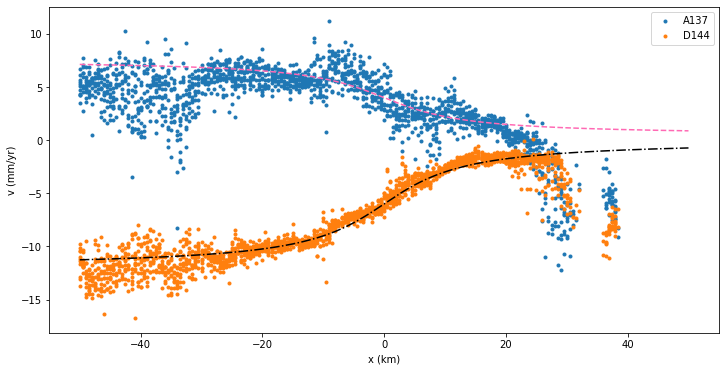

In [88]:
s = 24
D = 10
asc_shift = 4     # estimate the shifts needed by eyeballing the plot from section 3 above
dsc_shift = -6

# calculate your forward model
v = (s/np.pi)*np.arctan(p/D)      # recall that the 'p' vector is the vector of along-profile distances

# next, project it into the LOS for each InSAR dataset 
v_asc=v*(fault_dx*asc_los[0,0]+fault_dy*asc_los[1,0])+asc_shift
v_dsc=v*(fault_dx*dsc_los[0,0]+fault_dy*dsc_los[1,0])+dsc_shift


plt.figure(figsize=(12,6))

# plot the data as dots, matplotlib will assign colors
plt.scatter(samp_pts["P"], samp_pts[asc_tr], marker=".", label=asc_tr)  
plt.scatter(samp_pts["P"], samp_pts[dsc_tr], marker=".", label=dsc_tr)  

plt.plot(p,v_asc,linestyle='--',color='hotpink')
plt.plot(p,v_dsc,linestyle='-.',color='black')

# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
plt.legend()

plt.show()

In [71]:
# to assess the fit of the data, we can evaluate a penalty function: the WRSS penalty
# (weighted residual sum of squares)

# evaluate the model at the locations of our stations
v_fwd=(s/np.pi)*np.arctan(samp_pts["P"]/D)

v_asc_fwd=v_fwd*(fault_dx*asc_los[0,0]+fault_dy*asc_los[1,0])+asc_shift
v_dsc_fwd=v_fwd*(fault_dx*dsc_los[0,0]+fault_dy*dsc_los[1,0])+dsc_shift

# the penalty function is calculated by subtracting the forward model from the data, squaring and adding
WRSS_asc=np.sum(np.square((samp_pts[asc_tr]-v_asc_fwd)))
WRSS_dsc=np.sum(np.square((samp_pts[dsc_tr]-v_dsc_fwd))) 
WRSS=WRSS_asc+WRSS_dsc
                   
print('Total WRSS penalty: {0:6.3f} (mm/yr)^2, {1} WRSS penalty: {2:6.3f}, {3} WRSS penalty: {4:6.3f} '
      .format(WRSS,asc_tr,WRSS_asc,dsc_tr, WRSS_dsc))

Total WRSS penalty: 39991.701 (mm/yr)^2, A137 WRSS penalty: 31483.128, D144 WRSS penalty: 8508.573 


Have a play around, changing the parameters, and see how low you can get the WRSS penalty. Record your best penalty values below:

In [ ]:
# best trial-and-error model parameters
s_best =
D_best = 
asc_shift_best = 
dsc_shift_best = 

# and the corresponding best penalty
v_best=(s_best/np.pi)*np.arctan(samp_pts["P"]/D_best)
v_asc_best=v_best*(fault_dx*asc_los[0,0]+fault_dy*asc_los[1,0])+asc_shift_best
v_dsc_best=v_best*(fault_dx*dsc_los[0,0]+fault_dy*dsc_los[1,0])+dsc_shift_best
WRSS_best=np.sum(np.square((samp_pts[asc_tr]-v_asc_fwd)))+np.sum(np.square((samp_pts[dsc_tr]-v_dsc_fwd))) 

## 6. Using a grid search to identify a preferred model

Of course, we don't have to do everything by trial and error! One way that we can approach this problem is by systematically evaluating different combinations of slip rate and locking depth via a 'grid search'. In a grid search, we define _a priori_ ranges of the parameters to test, evaluate each combination of them, and look for the lowest value of the penalty, which corresponds to the preferred set of model parameters.

In [92]:
# OK, let's run a grid search!

# model parameters
s_min = 16  # lowest slip rate
s_max = 36  # highest slip rate
s_step = 2  # slip rate increment

D_min = 6  # shallowest locking depth
D_max = 26  # deepest locking depth
D_step = 2  # locking depth increment

# set up the parameter value ranges
n_s = round(1+(s_max-s_min)/s_step)
s_set = np.linspace(s_min,s_max,n_s)
n_D = round(1+(D_max-D_min)/D_step)
D_set = np.linspace(D_min,D_max,n_D)

# set up arrays for the results
sv, Dv = np.meshgrid(s_set,D_set)
WRSS=np.zeros((np.shape(sv)))

# and loop!
for i in range(n_D):
    for j in range(n_s):
        v_fwd=(sv[i,j]/np.pi)*np.arctan(samp_pts["P"]/Dv[i,j])
        v_asc_fwd=v_fwd*(fault_dx*asc_los[0,0]+fault_dy*asc_los[1,0])
        v_dsc_fwd=v_fwd*(fault_dx*dsc_los[0,0]+fault_dy*dsc_los[1,0])
        asc_shift=np.mean(samp_pts[asc_tr]-v_asc_fwd)
        dsc_shift=np.mean(samp_pts[dsc_tr]-v_dsc_fwd)

# the penalty function is calculated by subtracting the forward model from the data, squaring and adding
        WRSS[i,j]=np.sum(np.square((samp_pts[asc_tr]-v_asc_fwd-asc_shift)))+np.sum(np.square((samp_pts[dsc_tr]-v_dsc_fwd-dsc_shift))) 

In [93]:
# what was the best model?
WRSS_best=np.amin(WRSS)                # find minimum value of WRSS
best_model=np.where(WRSS==WRSS_best)   # find the index for the minimum WRSS model

s_best=sv[best_model].item()           # use index to find best value of s...
D_best=Dv[best_model].item()           # ...and of D

# and evaluate the best model again
v_best=(s_best/np.pi)*np.arctan(samp_pts["P"]/D_best)
v_asc_best=v_best*(fault_dx*asc_los[0,0]+fault_dy*asc_los[1,0])
v_dsc_best=v_best*(fault_dx*dsc_los[0,0]+fault_dy*dsc_los[1,0])
asc_shift_best=np.mean(samp_pts[asc_tr]-v_asc_fwd)
dsc_shift_best=np.mean(samp_pts[dsc_tr]-v_dsc_fwd)
WRSS_best=np.sum(np.square((samp_pts[asc_tr]-v_asc_best-asc_shift_best)))+np.sum(np.square((samp_pts[dsc_tr]-v_dsc_best-dsc_shift_best))) 

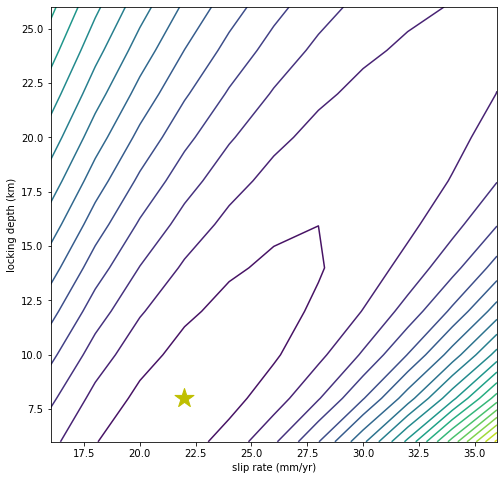

In [94]:
# make a contour plot?

plt.figure(figsize=(8,8))
plt.contour(sv,Dv,WRSS,20)
plt.scatter(s_best,D_best,s=400,c='y',marker='*')    # plot a big yellow star at the location of the best model

plt.xlabel("slip rate (mm/yr)")
plt.ylabel("locking depth (km)")

plt.show()

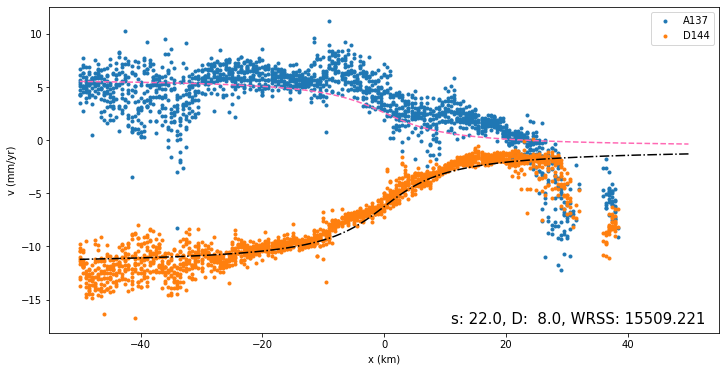

In [98]:
# calculate your best model, with additional shift, for plotting purposes
v = (s_best/np.pi)*np.arctan(p/D_best)

# next, project it into the LOS for each InSAR dataset 
v_asc=v*(fault_dx*asc_los[0,0]+fault_dy*asc_los[1,0])+asc_shift_best
v_dsc=v*(fault_dx*dsc_los[0,0]+fault_dy*dsc_los[1,0])+dsc_shift_best


plt.figure(figsize=(12,6))

# plot the data as dots, matplotlib will assign colors
plt.scatter(samp_pts["P"], samp_pts[asc_tr], marker=".", label=asc_tr)  
plt.scatter(samp_pts["P"], samp_pts[dsc_tr], marker=".", label=dsc_tr)  

plt.plot(p,v_asc,linestyle='--',color='hotpink')
plt.plot(p,v_dsc,linestyle='-.',color='black')

# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
plt.legend()
plt.text(0.6, 0.03, 's: {0:4.1f}, D: {1:4.1f}, WRSS: {2:5.3f}'.format(s_best,D_best,WRSS_best), 
         size=15, transform=plt.gca().transAxes)

plt.show()